In [1]:
import os
import re
import sys
import glob
import pickle
import tables
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *
import pypan.utils

#### Find the best experiment given a set of tags

In [2]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'inertia'
# area_IDs = [1, 2, 3]
D = 2
DZA = 60
energy_inertia = True
# num_stochastic_loads = 1
network_name = 'IEEE39'

if energy_inertia:
    tag = Tag('area_inertia_global')
    func = np.sum
    inertia_units = 'GW s'
    suffix = 'energy_inertia'
else:
    tag = Tag('area_inertia_coi')
    func = np.mean
    inertia_units = 's'
    suffix = 'coi_inertia'
query = Tag(network_name) & \
        Tag(f'D={D}') & \
        Tag(f'DZA={DZA}') & \
        Tag('1D_pipeline') & \
        tag
experiments = api.query(workspace, project_name, query, archived=False)
experiment_IDs = []
MAPE = []
val_loss = []
tags =  []
for experiment in experiments:
    ID = experiment.id
    experiment_IDs.append(ID)
    sys.stdout.write(f'Downloading data for experiment ID {ID}... ')
    metrics = experiment.get_metrics()
    sys.stdout.write('done.\n')
    val_loss.append(np.array([float(m['metricValue']) for m in metrics if m['metricName'] == 'val_loss']))
    has_MAPE = False
    for m in metrics:
        if m['metricName'] == 'mape_prediction':
            val = m['metricValue']
            try:
                MAPE.append(float(val))
            except:
                MAPE.append(list(map(float, [v for v in val[1:-1].split(' ') if len(v)])))
            has_MAPE = True
            break
    tags.append(experiment.get_tags())
    print(f'  val_loss: {val_loss[-1].min():.4f}')
    if has_MAPE:
        print(f'      MAPE: {MAPE[-1]}%')
    else:
        print('      MAPE: [experiment not terminated]')
    print('      Tags: "{}"'.format('" "'.join(tags[-1])))
# idx = np.argmin(MAPE)
idx = np.argmin([loss.min() for loss in val_loss])
experiment_ID = experiment_IDs[idx]
MAPE = MAPE[idx]
val_loss = val_loss[idx]
tags = tags[idx]
print(f'The best experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE}%).')

  val_loss: 0.3237
      MAPE: 5.570139408111572%
      Tags: "1D_pipeline" "area_inertia_global" "D=2" "DZA=60" "IEEE39" "neural_network" "ReLU_none"
The best experiment is fe088f (val_loss = 0.3237, MAPE = 5.570139408111572%).


In [3]:
experiments_path = '../experiments/neural_network/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
model = keras.models.load_model(best_checkpoint, compile=True)
data_dirs = ['..' + os.path.sep + os.path.sep.join([d for d in data_dir.split(os.path.sep) if '{}' not in d]) \
             for data_dir in network_parameters['data_dirs']]
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
data_dir = data_dirs[0]
if not os.path.isdir(data_dir):
    raise Exception(f'{data_dir}: no such directory')
print(f'Loaded network from {best_checkpoint}.')
print(f'Data directory is {data_dir}.')

Loaded network from ../experiments/neural_network/fe088f57231c4d2cb4aa9d51cd0a03b3/checkpoints/weights.0068-0.323659.h5.
Data directory is ../data/IEEE39/IEEE39_D=2_DZA=60.0.


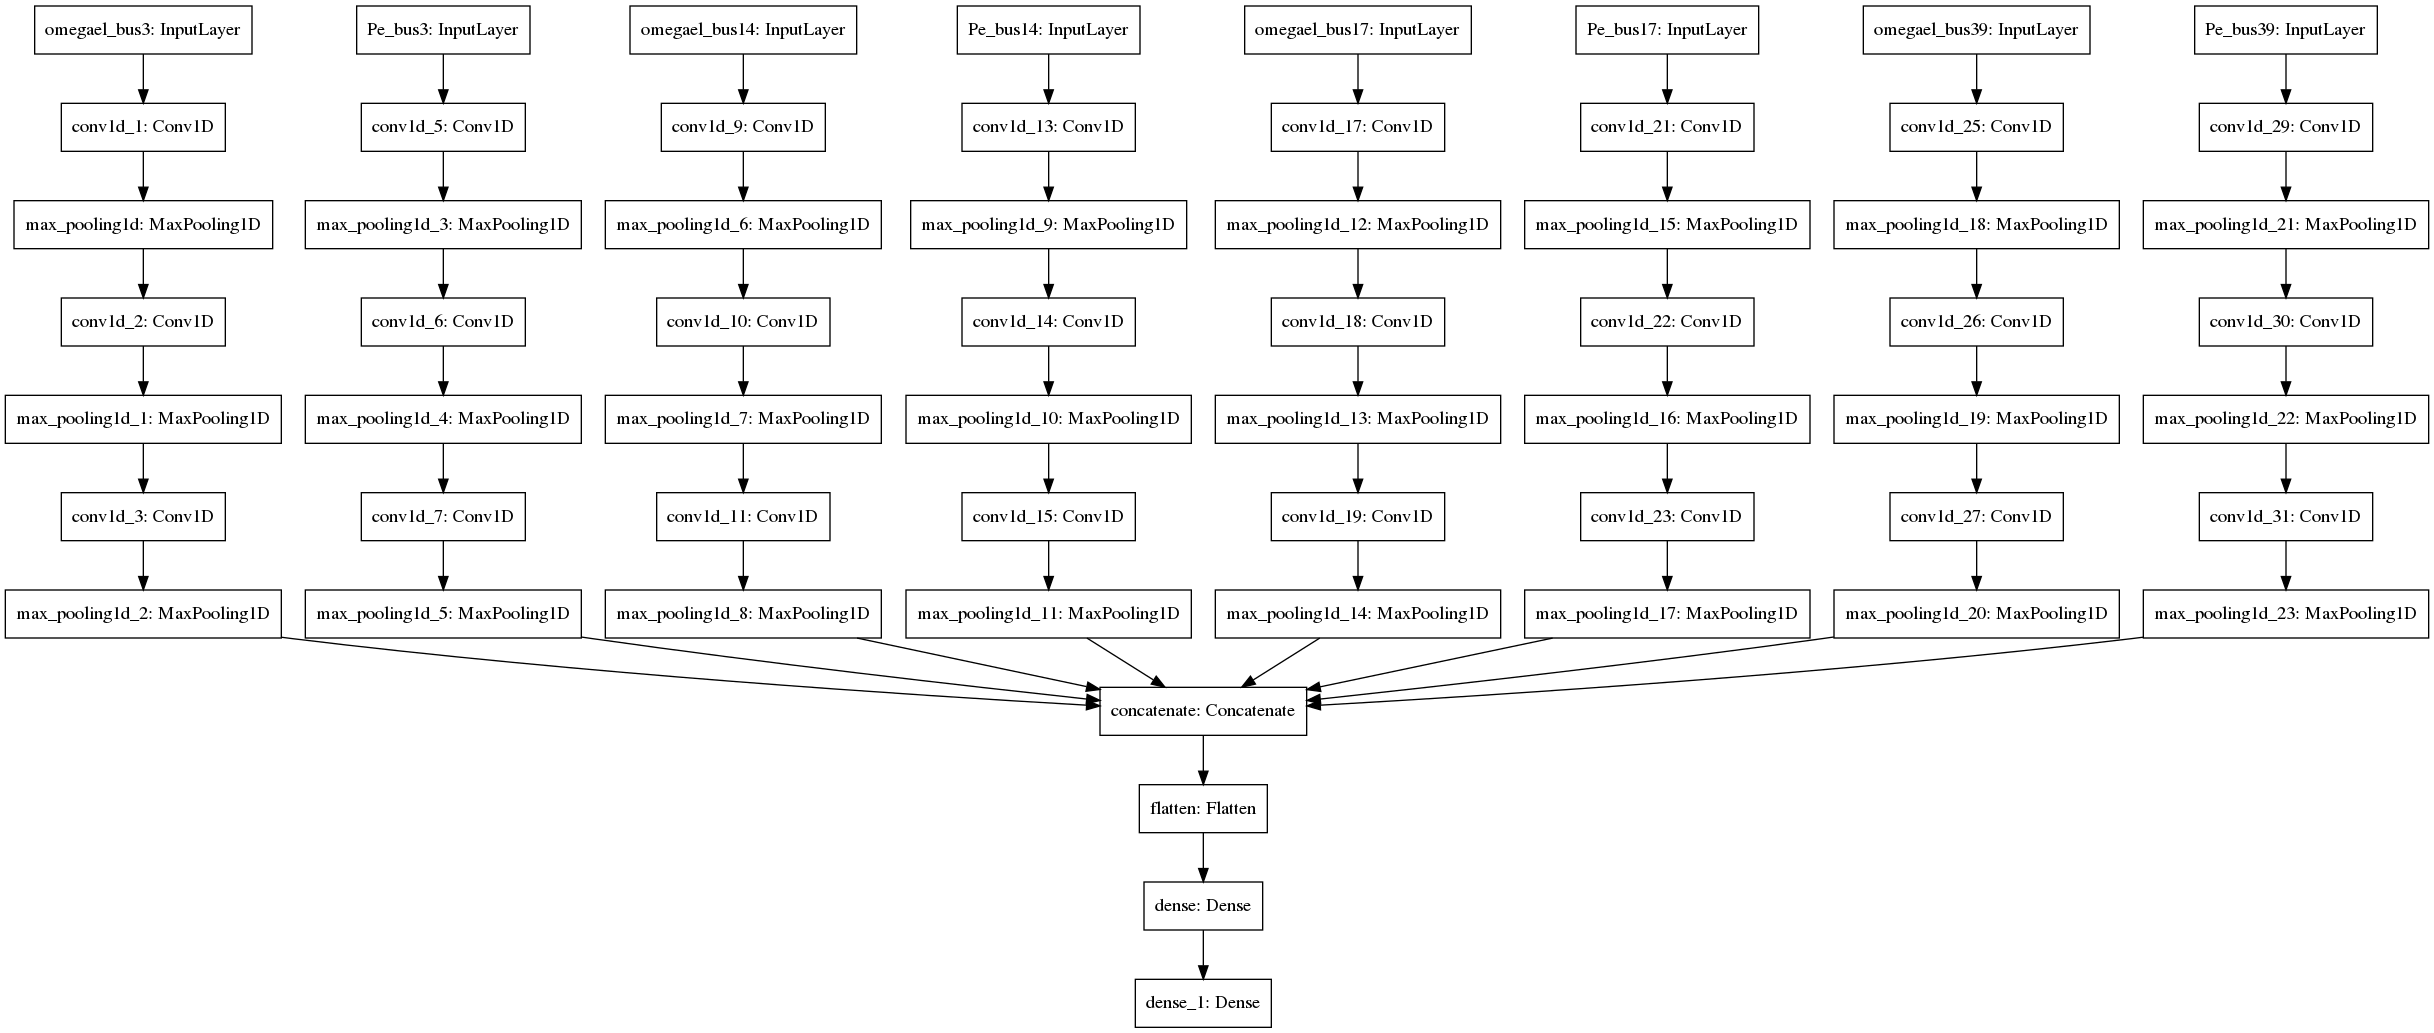

In [4]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

## Constant inertia
1. the value of inertia of area 1 is either 5.405 or 6.0 GW s
1. **omega** and **Pe** of the three areas are used for the estimation

In [5]:
default_H = OrderedDict([
    ('Pg30', 250), ('Pg31', 15.15), ('Pg32', 17.9), ('Pg33', 14.3), ('Pg34', 13),
    ('Pg35', 17.4), ('Pg36', 13.2), ('Pg37', 12.15), ('Pg38', 17.25), ('Pg39', 21)

])
P_nom = {gen_ID: 100e6 for gen_ID in default_H}

generators_areas_map = [
    ['Pg31', 'Pg32', 'Pg39']
]

window_dur = 60
window_step = 10

H_values = [
    default_H,
    OrderedDict([
        ('Pg30', 250), ('Pg31', 17), ('Pg32', 20), ('Pg33', 14.3), ('Pg34', 13),
        ('Pg35', 17.4), ('Pg36', 13.2), ('Pg37', 12.15), ('Pg38', 17.25), ('Pg39', 23)

    ])
]
N_H = len(H_values)

area_inertia = []

bus_IDs = [3, 14, 17, 39]

data_normalized = []
inertia = []

var_names = [var_name.format(bus_ID) for bus_ID in np.unique(bus_IDs) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for H in H_values:
    tmp_inertia = []
    for generator_IDs in generators_areas_map:
        tmp_inertia.append(np.sum([P_nom[gen_ID] * H[gen_ID] for gen_ID in generator_IDs]) * 1e-9)
    area_inertia.append(tmp_inertia)
    data_file = data_dir + '/inertia_' + '_'.join(map(lambda h: f'{h:.3f}', H.values())) + '.h5'

    t, _, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

Window size: 600 samples
Number of trials: 1740
Window size: 600 samples
Number of trials: 1740


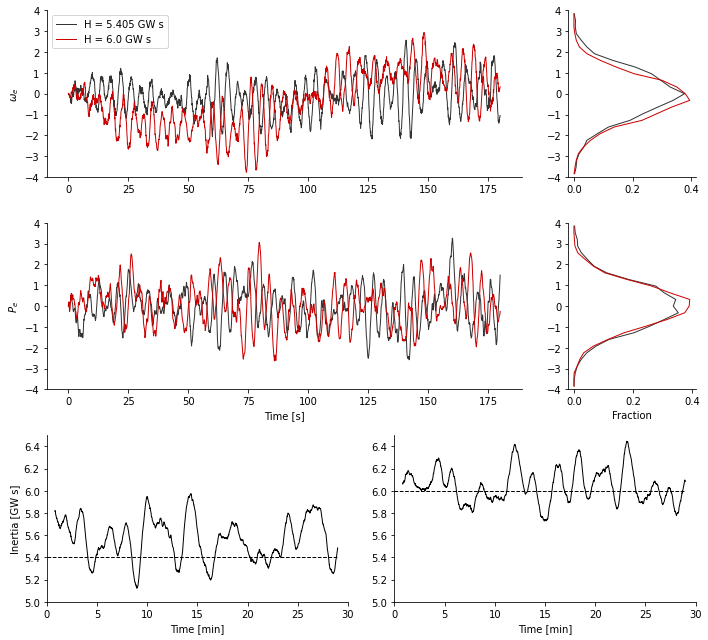

In [6]:
fig = plt.figure(figsize=(10, 3 * 3))
gs = fig.add_gridspec(3, 4)
ax = []
ax.append([fig.add_subplot(gs[0, :3]), fig.add_subplot(gs[0, 3])]),
ax.append([fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[1, 3])]),
ax.append([fig.add_subplot(gs[2, :2]), fig.add_subplot(gs[2, 2:])])

col = [[.2,.2,.2], [.8,0,0]]

var_names = 'omegael_bus{}','Pe_bus{}'
bus_ID = 14

idx = t < 180
for i in range(N_H):
    for j,var_name in enumerate(var_names):
        key = var_name.format(bus_ID)
        value = data_normalized[i][key]
        n,edges = np.histogram(value, bins=25, range=(-4,4), density=True)
        ax[j][0].plot(t[idx], value[idx], color=col[i], lw=1, label=f'H = {area_inertia[i][0]} {inertia_units}')
        ax[j][1].plot(n, edges[:-1] + np.diff(edges[:2])[0] / 2, color=col[i], lw=1)
        for a in ax[j]:
            a.set_ylim([-4,4])
    ax[-1][i].plot(time / 60, inertia[i], 'k', lw=1)
    ax[-1][i].plot(time[[0,-1]] / 60, area_inertia[i][0] + np.zeros(2), 'k--', lw=1)
    ax[-1][i].set_ylim([5, 6.5])
    ax[-1][i].set_xlabel('Time [min]')

for a in ax:
    for side in 'right','top':
        for i in range(2):
            a[i].spines[side].set_visible(False)

ax[0][0].legend(loc='best')

for i in range(0, len(ax)-1, 2):
    ax[i][0].set_ylabel(r'$\omega_{e}$')
    ax[i+1][0].set_ylabel(r'$P_{e}$')
ax[-1][0].get_shared_x_axes().join(ax[-1][0], ax[-1][1])

ax[-1][0].set_xlim([0,30])
ax[-1][0].set_ylabel(f'Inertia [{inertia_units}]')
ax[-2][0].set_xlabel('Time [s]')
ax[-2][1].set_xlabel('Fraction')
fig.tight_layout()
# fig.savefig(f'multi_area_prediction_const_H_{suffix}.pdf')

## Step of inertia
1. H steps **instantaneously** from 3.5 to 3.8
1. **omega** and **Pe** of the both areas used for the estimation

In [17]:
var_names = [var_name.format(bus_ID) for bus_ID in np.unique(bus_IDs) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

data_file = data_dir + '/inertia_step.h5'
t, _, data_normalized, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
dt = np.diff(t[:2])[0]
time, inertia, _ = predict(model, data_sliding, window_step, dt)

Window size: 600 samples
Number of trials: 3540


In [24]:
fid = tables.open_file(data_file)
pars = fid.root.parameters.read()
fid.close()
H = pars['inertia'][0]
P = 100e6 * np.ones(H.shape[0])
generator_IDs = list(map(lambda x: x.decode('utf-8'), pars['generator_IDs'][0]))
idx = np.array([generator_IDs.index(f'Pg{gen_ID}') for gen_ID in (31,32,39)])
area_inertia = np.array([H[[1,2,9], i] @ np.array([100e6 for _ in range(idx.size)]) * 1e-9 for i in range(2)])

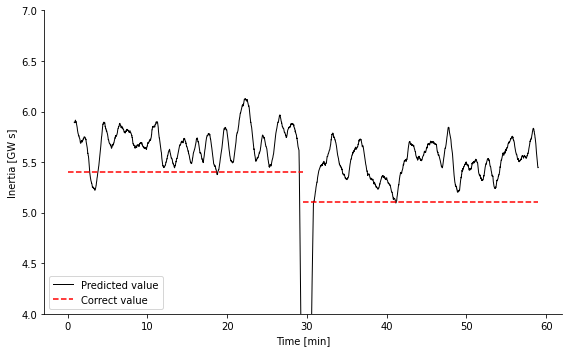

In [63]:
fig,ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(time / 60, inertia, 'k', lw=1, label='Predicted value')
ax.plot(time[[0, time.size//2]] / 60, area_inertia[0] + np.zeros(2), 'r--', label='Correct value')
ax.plot(time[[time.size//2, -1]] / 60, area_inertia[1] + np.zeros(2), 'r--')
ax.legend(loc='lower left')
ax.set_xlabel('Time [min]')
ax.set_ylabel(f'Inertia [{inertia_units}]')
for side in 'top','right':
    ax.spines[side].set_visible(False)
ax.set_ylim([4,7])
fig.tight_layout()

## Steps of inertia with transient
1. the inertia of area 1 steps from 6.5 to 5.5 at 20 s
1. the inertia of area 2 steps from 6.175 to 6.5 at 40 s
1. **omega** and **Pe** of the both areas used for the estimation
1. one single simulation

In [ ]:
data_file = data_dir + '/inertia_steps.h5'

H_values = [
    [6.5, 6.5, 6.175, 6.175],
    [5.5, 5.5, 6.175, 6.175],
    [5.5, 5.5, 6.500, 6.500]
]

window_dur = 60
window_step = 10

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

t, _, data_normalized, data_sliding, _ = load_data_slide([data_file],
                                                         var_names,
                                                         data_mean,
                                                         data_std,
                                                         window_dur,
                                                         window_step,
                                                         verbose = True)

dt = np.diff(t[:2])[0]
time, inertia, _ = predict(model, data_sliding, window_step, dt)

In [ ]:
fig = plt.figure(figsize = (6,9))
gs = fig.add_gridspec(8, 1)
ax = [
    fig.add_subplot(gs[:2,0]),
    fig.add_subplot(gs[2:4,0]),
    fig.add_subplot(gs[4:-1,0]),
    fig.add_subplot(gs[-1,0])
]

ds = 5
ax[0].plot(t[::ds] / 60, data_normalized['omegael_bus7'][::ds], color=col[0], lw=1, label='bus7')
ax[0].plot(t[::ds] / 60, data_normalized['omegael_bus9'][::ds], color=col[1], lw=1, label='bus9')
ax[1].plot(t[::ds] / 60, data_normalized['Pe_bus7'][::ds], color=col[0], lw=1)
ax[1].plot(t[::ds] / 60, data_normalized['Pe_bus9'][::ds], color=col[1], lw=1)
ax[0].set_ylim([-5,5])
ax[1].set_ylim([-5,5])

ylim = [func(H_values[1][:2]) - 1, func(H_values[2][2:]) + 1]
ax[2].plot(time[::ds] / 60, inertia[::ds,0], color=col[0])
ax[2].plot(time[::ds] / 60, inertia[::ds,1], color=col[1])
ax[2].set_ylim(ylim)
ax[2].plot([0, 20], func(H_values[0][:2]) + np.zeros(2), '--', color=col[0], lw=1)
ax[2].plot([20, 60], func(H_values[1][:2]) + np.zeros(2), '--', color=col[0], lw=1)
ax[2].plot([0, 40], func(H_values[0][2:]) + np.zeros(2), '--', color=col[1], lw=1)
ax[2].plot([40, 60], func(H_values[2][2:]) + np.zeros(2), '--', color=col[1], lw=1)

ax[3].plot([0, 20], func(H_values[0][:2]) + np.zeros(2), '-', color=col[0], lw=2)
ax[3].plot([20, 60], func(H_values[1][:2]) + np.zeros(2), '-', color=col[0], lw=2)
ax[3].plot([0, 40], func(H_values[0][2:]) + np.zeros(2), '-', color=col[1], lw=2)
ax[3].plot([40, 60], func(H_values[2][2:]) + np.zeros(2), '-', color=col[1], lw=2)
ax[3].plot(20 + np.zeros(2), ylim, '--', color=col[0], lw=1)
ax[3].plot(40 + np.zeros(2), ylim, '--', color=col[1], lw=1)
ax[3].set_ylim(ylim)
ax[3].set_xlabel('Time [min]')

ax[0].legend(loc='lower right')

for a in ax:
    a.set_xlim([-1,61])
    for side in 'right', 'top':
        a.spines[side].set_visible(False)
    if a != ax[-1]:
        a.set_xticklabels([])

ax[0].set_ylabel(r'$\omega_{e}$')
ax[1].set_ylabel(r'$P_{e}$')
ax[2].set_ylabel(f'Inertia [{inertia_units}]')
ax[3].set_ylabel(f'Inertia [{inertia_units}]')

fig.tight_layout()
fig.savefig(f'multi_area_prediction_steps_H_{suffix}.pdf')

# Three generators in Area 1

We want to see whether we can use a neural network that has been trained with two generators in each area to estimate the inertia of an area with a different number of generators.

Hypotheses:
1. the total **nominal** power in an area does not change
1. the electrical power of each generator that is not affected by the addition of new generators stays the same

Area 1 of the two-area network contains the following generators:
1. G1: H = 6.5 s, nominal power = 1 GW, slack generator (prating=1GW)
1. G2: H = 6.5 s, nominal power = 1 GW, mechanical power = 700 MW (prating=1GW, pg=0.7)

Area 2 of the two-area network contains the following generators:
1. G3: H = 6.175 s, nominal power = 1 GW, mechanical power = 719 MW (prating=1GW, pg=0.719)
1. G4: H = 6.175 s, nominal power = 1 GW, mechanical power = 700 MW (prating=1GW, pg=0.7)

## Test 1

#### Power settings
We start by comparing the original two-area network with a new network that has the following three generators in area 1:
1. G1: H = 6.5 s, nominal power = 1 GW, slack generator (prating=1GW)
1. G2a: H = 6.5 s, nominal power = 500 MW, mechanical power = 350 MW (prating=0.5GW, pg=0.7)
1. G2b: H = 6.5 s, nominal power = 500 MW, mechanical power = 350 MW (prating=0.5GW, pg=0.7)

We also show what happens when the total nominal power in the area changes, i.e., when we set a nominal power for G2a and G2b of 1 GW and set the parameter <tt>pg=0.35</tt>.

#### Bus(es) to which G2a and G2b are connected
The inertia estimation works similarly whether G2a is connected to bus 6 or 5 (where G1 is also connected). G2b is always connected to bus 6, as G2 is in the original two-area network.

In [ ]:
H = [
    [6.5, 6.5, 6.175, 6.175],
    [9.75, 9.75, 6.175, 6.175],
    [6.5, 6.5, 6.5, 6.175, 6.175],
    [6.5, 6.5, 6.5, 6.175, 6.175]
]
N_gen = [2, 2, 3, 3]
prating = [
    [1., 1., 1., 1.],
    [1., 1., 1., 1.],
    [1., 1., 1., 1., 1.],
    [1., 0.5, 0.5, 1., 1.]
]

pg = [0.7, 0.7, 0.35, 0.7]
bus_ID = 6

if energy_inertia:
    H_area_1 = [np.dot(p[:-2], h[:-2]) for p,h in zip(prating, H)]
    H_area_2 = np.dot(H[0][-2:], prating[0][-2:])
else:
    H_area_1 = [np.dot(p[:-2], h[:-2]) / np.sum(p[:-2]) for p,h in zip(prating, H)]
    H_area_2 = np.dot(H[0][-2:], prating[0][-2:]) / np.sum(prating[0][-2:])
    
data_files = [
    data_dir + f'/inertia_{H[0][0]:.3f}_{H[0][1]:.3f}_{H[0][2]:.3f}_{H[0][3]:.3f}.h5',
    data_dir + f'/inertia_{H[1][0]:.3f}_{H[1][0]:.3f}_{H[1][2]:.3f}_{H[1][3]:.3f}.h5',
    data_dir + f'/inertia_{H[2][0]:.3f}_{H[2][1]:.3f}_{H[2][2]:.3f}_{H[2][3]:.3f}_{H[2][4]:.3f}_' + \
        f'prating={prating[2][1]:.1f}GW_pg={pg[2]}_bus{bus_ID}.h5',
    data_dir + f'/inertia_{H[3][0]:.3f}_{H[3][1]:.3f}_{H[3][2]:.3f}_{H[3][3]:.3f}_{H[3][4]:.3f}_' + \
        f'prating={prating[3][1]:.1f}GW_pg={pg[3]}_bus{bus_ID}.h5'
]
labels = [f'{N_gen[i]} gen H={H_area_1[i]}{inertia_units} P={prating[i][-3]:.1f}GW pg={pg[i]:g}' for i in range(len(H))]
    
window_dur = 60
window_step = 10

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

t = []
data = []
data_normalized = []
data_sliding = []
time = []
inertia = []

for data_file in data_files:
    tt, dat, data_norm, data_slid, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
    t.append(tt)
    data.append(dat)
    data_normalized.append(data_norm)
    data_sliding.append(data_slid)
    dt = np.diff(tt[:2])[0]

    tt, hh, _ = predict(model, data_slid, window_step, dt)
    time.append(tt)
    inertia.append(hh)

In [ ]:
units = {'omegael': 'pu', 'Pe': 'MW'}
coeff = {'omegael': 1, 'Pe': 1e-6}
for i in range(len(data)):
    print('-' * len(data_files[i]))
    print(data_files[i])
    for var in 'omegael','Pe':
        for bus in 7,9:
            m = data[i][f'{var}_bus{bus}'].mean() * coeff[var]
            s = data[i][f'{var}_bus{bus}'].std() * coeff[var]
            print(f'{var:>8s}_bus{bus}: {m:>8.3f} +- {s:<5.3f} {units[var]}')

In [ ]:
def read_stats(raw_file, var_names, Pnom):
    raw_data = pypan.utils.load_vars(raw_file, var_names)
    for i,var_name in enumerate(var_names):
        m = raw_data[var_name].mean() * Pnom[i] * 1e-6
        s = raw_data[var_name].std() * Pnom[i] * 1e-6
        print(f'{var_name:>5s}: {m:>5.0f} MW')

raw_file = data_dir + '/inertia_6.500_6.500_6.175_6.175_prating=1.0GW_pg=0.7.raw/Tr'
print('-' * len(raw_file))
print(raw_file)
var_names = tuple(f'pm0{i+1}' for i in range(4))
Pnom = [1e9 for _ in var_names]
read_stats(raw_file, var_names, Pnom)

var_names = 'pm01','pm02a','pm02b','pm03','pm04'
Pnom = [1e9 for _ in var_names]
for data_file in data_files[-2:]:
    raw_file = os.path.splitext(data_file)[0] + '.raw/Tr'
    print('-' * len(raw_file))
    print(raw_file)
    if '0.5GW' in raw_file:
        Pnom[1] = 0.5e9
        Pnom[2] = 0.5e9
    else:
        Pnom[1] = 1e9
        Pnom[2] = 1e9
    read_stats(raw_file, var_names, Pnom)

In [ ]:
col = [[0,0,0], [.8,0,.8], [1,0.5,0], [0,.8,0], [0,0,1]]

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2, 2)
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[1,0]),
    fig.add_subplot(gs[:,1])
]

for i,(tt,hh) in enumerate(zip(time, inertia)):
    for j in range(2):
        if j == 1:
            ax[2].plot(tt / 60, hh[:,j], color=col[i], lw=1, label=labels[i])
        elif i < 2:
            ax[1 - i].plot(tt / 60, hh[:,j], color=col[i], lw=1, label=labels[i])
        else:
            ax[i - 2].plot(tt / 60, hh[:,j], color=col[i], lw=1, label=labels[i])

ax[0].plot(time[0][[0,-1]] / 60, H_area_1[1] + np.zeros(2), '--', color=[1,1,.2], lw=2)
ax[1].plot(time[0][[0,-1]] / 60, H_area_1[0] + np.zeros(2), '--', color=[1,1,.2], lw=2)
ax[2].plot(time[0][[0,-1]] / 60, H_area_2 + np.zeros(2), '--', color=[1,1,.2], lw=2)


ax[0].legend(loc='best', fontsize=8)
ax[1].legend(loc='best', fontsize=8)
ax[0].set_title('Area 1')
ax[2].set_title('Area 2')
for a in ax:
    for side in 'top','right':
        a.spines[side].set_visible(False)
    a.set_ylabel(f'Inertia [{inertia_units}]')
ax[1].set_xlabel('Time [min]')
ax[2].set_xlabel('Time [min]')

for i in 1,2:
    ax[0].get_shared_x_axes().join(ax[0], ax[i])

ax[0].set_xlim([0, 60])
ax[0].set_xticklabels([])

fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_three_gen_bus_{bus_ID}_inertia_estimation_{suffix}.{ext}')

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig,ax = plt.subplots(1, 2, sharex=True, figsize=(10,4))
j = 0
for i,data_norm in enumerate(data_normalized):
    for j,var_name in enumerate(var_names):
        y, edges = np.histogram(data_norm[var_name], bins=31, range=(-3,3), density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j].plot(x, y, color=col[i], lw=1, label=labels[i])
ax[0].legend(loc='lower left', fontsize=8)

for a in ax:
    for side in 'top','right':
        a.spines[side].set_visible(False)
ax[0].set_xlabel(r'Norm. $\omega_{e}$')
ax[1].set_xlabel(r'Norm. $P_{e}$')
ax[0].set_ylabel('Fraction')

fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_three_gen_bus_{bus_ID}_var_distr_{suffix}.{ext}')

## Test 2

#### Power settings
What is the area inertia estimated by the neural network when the three generators in Area 1 have the following settings?
1. G1: H = 6.5 s, nominal power = 1 GW, slack generator (prating=1GW)
1. G2a: H = 6.5 s, nominal power = 500 MW, mechanical power = 350 MW (prating=0.5GW, pg=0.7)
1. G2b: H = 2.5 s, nominal power = 500 MW, mechanical power = 350 MW (prating=0.5GW, pg=0.7)

By using the inertia of the COI, we would expect the following value of inertia for Area 1:

\begin{equation}
H_{COI} = \frac{\sum_i^N H_i P_i}{\sum_i^N P_i} = \frac{6.5 \cdot 10^9 + 6.5 \cdot 5 \cdot 10^8 + 2.5 \cdot 5 \cdot 10^8}{2 \cdot 10^9} = 5.5\,s
\end{equation}

By using the actual inertia of the area, we would expect the following value of inertia for Area 1:

\begin{equation}
H_{COI} = \sum_i^N H_i P_i = 6.5 \cdot 10^9 + 6.5 \cdot 5 \cdot 10^8 + 2.5 \cdot 5 \cdot 10^8 = 11 GW s
\end{equation}

In [ ]:
H = [[6.5, 6.5, 2.5, 6.175, 6.175]]
Pnom = [[1e9, 0.5e9, 0.5e9, 1e9, 1e9]]
prating = [0.5]
pg = [0.7]
bus_ID = [6]

data_files = [data_dir + f'/inertia_{h[0]:.3f}_{h[1]:.3f}_{h[2]:.3f}_{h[3]:.3f}_{h[4]:.3f}_' + \
        f'prating={pnom:.1f}GW_pg={ppg}_bus{bus}.h5' for h,pnom,ppg,bus in zip(H, prating, pg, bus_ID)]

bus_IDs = [7, 9]

window_dur = 60
window_step = 10

var_names = [var_name.format(bus_ID) for bus_ID in bus_IDs for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

t = []
data = []
data_normalized = []
data_sliding = []
time = []
inertia = []

for data_file in data_files:
    tt, dat, data_norm, data_slid, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
    t.append(tt)
    data.append(dat)
    data_normalized.append(data_norm)
    data_sliding.append(data_slid)
    dt = np.diff(tt[:2])[0]

    tt, hh, _ = predict(model, data_slid, window_step, dt)
    time.append(tt)
    inertia.append(hh)

In [ ]:
if energy_inertia:
    H_area_1 = np.dot(H[0][:3], Pnom[0][:3]) * 1e-9
    H_area_2 = np.dot(H[0][3:], Pnom[0][3:]) * 1e-9
else:
    H_area_1 = np.dot(H[0][:3], Pnom[0][:3]) / np.sum(Pnom[0][:3])
    H_area_2 = np.dot(H[0][3:], Pnom[0][3:]) / np.sum(Pnom[0][3:])

fig,ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(time[0][[0,-1]] / 60, H_area_1 + np.zeros(2), '--', lw=2, color=[0.6,0.6,0.6])
ax.plot(time[0][[0,-1]] / 60, H_area_2 + np.zeros(2), '--', lw=2, color=[1,0.6,0.6])
ax.plot(time[0] / 60, inertia[0][:,0], color='k', label='Area 1')
ax.plot(time[0] / 60, inertia[0][:,1], color='r', label='Area 2')
ax.legend(loc='right')
ax.set_xlabel('Time [min]')
ax.set_ylabel(f'Inertia [{inertia_units}]')
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.set_xlim([0, 60])
fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_three_gen_bus_{bus_ID[0]}_inertia_estimation_distinct_H_{suffix}.{ext}')

# Inertia estimation of an overloaded area

We want to test whether a neural network trained on the standard two-area system can correctly infer the values of area inertia when one of the two areas is overloaded. To do so, we multiply both the power generated by the generators and the (active and reactive) power absorbed by the load in area 2 by the coefficient $(1 + \lambda)$.

We have verified in [another notebook](./Area_2_overload.ipynb) that the value of $\lambda$ for which the two-area system becomes unstable is around $1.375$, as shown in the figure below.

![foo](./area_2_overload.png)

**Important notes**:
1. we consider values of $\lambda$ in the range $[0,0.8]$.
1. the inertia of the 4 generators is fixed at their default values.
1. when $\lambda \neq 0$ we perform the normalization using the mean of the data itself and the standard deviation of the training set. If instead we were to use the mean of the training set, the prediction would fail.

In [ ]:
default_H = [6.5, 6.5, 6.175, 6.175]
H = default_H

window_dur = 60
window_step = 10

data_files = glob.glob(data_dir + f'/inertia_{H[0]:.3f}_{H[1]:.3f}_{H[2]:.3f}_{H[3]:.3f}_lambda=*.h5')
lambdas = np.array([float(re.findall('lambda=\d.\d+', data_file)[0].split('=')[-1]) for data_file in data_files])
N_lambdas = lambdas.size
idx = np.argsort(lambdas)
lambdas = lambdas[idx]
data_files = [data_files[i] for i in idx]

data = []
data_normalized = []
inertia = []

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for data_file, lam in zip(data_files, lambdas):
    t, dat, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                         var_names,
                                                         None if lam > 0 else data_mean,
                                                         data_std,
                                                         window_dur,
                                                         window_step,
                                                         ttran = 500,
                                                         verbose = True)
    data.append(dat)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

#### Estimated inertia

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(10,4))
cmap = plt.get_cmap('jet', N_lambdas + 1)
for i in range(2):
    ax[i].plot([0, time[-1]/60], H[0 + i*2] + H[1 + i*2] + np.zeros(2), '--', lw=3, color=[.6,.6,.6])
    for j,lam in enumerate(lambdas):
        ax[i].plot(time / 60, inertia[j][:,i], color=cmap(j), lw=1, label=r'$\lambda={:.2f}$'.format(lam))
    for side in 'right','top':
        ax[i].spines[side].set_visible(False)
    ax[i].set_xlabel('Time [min]')
    ax[i].set_title(f'Area {i+1}')
ax[1].legend(loc='lower right')
ax[0].set_ylabel(f'Inertia [{inertia_units}]')
fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_area_2_overloaded.{ext}')

#### Non-normalized data used for prediction

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(2, 4)
ax = [
    [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0,3:])],
    [fig.add_subplot(gs[1,:3]), fig.add_subplot(gs[1,3:])]
]

ylim = [[0.91,1.005], [0.93e9, 1.3e9]]

for i,dat in enumerate(data):
    for j,var_name in enumerate(var_names):
        ax[j][0].plot(t / 60, dat[var_name], color=cmap(i), lw=1)
        y, edges = np.histogram(dat[var_name], bins=1001, range=ylim[j], density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j][1].plot(y, x, color=cmap(i), lw=1)

for i in range(2):
    for j in range(2):
        for side in 'top','right':
            ax[i][j].spines[side].set_visible(False)
        ax[i][j].set_ylim(ylim[i])
ax[0][0].set_ylabel(r'$\omega_{e}$')
ax[0][0].set_xlabel('Time [min]')
ax[0][1].set_xlabel('PDF')
ax[1][0].set_ylabel(r'$P_{e}$')
ax[1][0].set_xlabel('Time [min]')
ax[1][1].set_xlabel('PDF')
ax[0][0].set_xlim([40, 50])
ax[1][0].set_xlim([40, 50])

fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_area_2_overload_non-normalized_data.{ext}')

#### Normalized data used for prediction

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(2, 4)
ax = [
    [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0,3:])],
    [fig.add_subplot(gs[1,:3]), fig.add_subplot(gs[1,3:])]
]

ylim = -10, 10

for i,data_norm in enumerate(data_normalized):
    for j,var_name in enumerate(var_names):
        ax[j][0].plot(t / 60, data_norm[var_name], color=cmap(i), lw=1)
        y, edges = np.histogram(data_norm[var_name], bins=101, range=ylim, density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j][1].plot(y, x, color=cmap(i), lw=1)

for i in range(2):
    for j in range(2):
        for side in 'top','right':
            ax[i][j].spines[side].set_visible(False)
        ax[i][j].set_ylim(ylim)
ax[0][0].set_ylabel(r'Norm. $\omega_{e}$')
ax[0][0].set_xlabel('Time [min]')
ax[0][1].set_xlabel('PDF')
ax[1][0].set_ylabel(r'Norm. $P_{e}$')
ax[1][0].set_xlabel('Time [min]')
ax[1][1].set_xlabel('PDF')
ax[0][0].set_xlim([40, 50])
ax[1][0].set_xlim([40, 50])

fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_area_2_overloaded_normalized_data.{ext}')

# Variable number of random loads

We want to see whether a neural network that has been trained on data generated by a power system containing only one stochastic load can accurately predict the inertia of a system containing three stochastic loads.

## Test 1

Fixed value of inertia in the two areas and variable standard deviation of the noise in the two areas.

In [ ]:
default_H = [6.5, 6.5, 6.175, 6.175]

window_dur = 60
window_step = 10

H_values = [
    default_H,
    default_H
]
N_H = len(H_values)
# standard deviation of the OU noise simulating the stochastic loads in the two areas
c = [0.5, 0.5, 0.5]
suffixes = ['1_random_load', f'{len(c)}_random_loads']
c_suffixes = ['', '_c=' + ','.join(map(str, c))]
data = []
data_normalized = []
inertia = []

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for H, suffix, c_suffix in zip(H_values, suffixes, c_suffixes):
    data_file = data_dir + f'/inertia_{H[0]:.3f}_{H[1]:.3f}_{H[2]:.3f}_{H[3]:.3f}_{suffix}{c_suffix}.h5'

    t, dat, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
    data.append(dat)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

In [ ]:
cmap = [[0,0,0], [1,0,0]]
fig,ax = plt.subplots(1, 2, figsize=(8,3))

ylim = {
    0.01 : [[12.5,13.3],[12,12.8]],
    0.05 : [[11,14], [11,14]],
    0.1 : [[10,16.5], [10,16.5]],
    0.5 : [[7,23], [7,23]],
}
for i in range(2):
    for j in range(2):
        col = np.min(np.array([np.array(cmap[j]) + np.array([.6,.6,.6]), [1,1,1]]), axis=0)
        ax[i].plot(time / 60, inertia[j][:,i], lw=1, color=col)
        ax[i].plot(time[[0,-1]] / 60, np.nanmean(inertia[j][:,i]) + \
                   np.zeros(2), lw=2, color=cmap[j])
    for side in 'right','top':
        ax[i].spines[side].set_visible(False)
    ax[i].set_xlabel('Time [min]')
    ax[i].set_title(f'Area {i+1}')
    ax[i].set_ylim(ylim[c[0]][i])
ax[0].set_ylabel(f'Inertia [{inertia_units}]')
fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_three_loads{c_suffixes[1]}_training_with_{num_stochastic_loads}_loads.{ext}')

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(2, 4)
ax = [
    [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0,3:])],
    [fig.add_subplot(gs[1,:3]), fig.add_subplot(gs[1,3:])]
]

for i,data_norm in enumerate(data_normalized):
    for j,var_name in enumerate(var_names):
        ax[j][0].plot(t / 60, data_norm[var_name], color=cmap[i], lw=1)
        y, edges = np.histogram(data_norm[var_name], bins=31, range=(-4,4), density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j][1].plot(y, x, color=cmap[i], lw=1)

for i in range(2):
    for j in range(2):
        for side in 'top','right':
            ax[i][j].spines[side].set_visible(False)
ax[0][0].set_ylabel(r'Norm. $\omega_{e}$')
ax[0][0].set_xlabel('Time [min]')
ax[0][1].set_xlabel('Fraction')
ax[1][0].set_ylabel(r'Norm. $P_{e}$')
ax[1][0].set_xlabel('Time [min]')
ax[1][1].set_xlabel('Fraction')
ax[0][0].set_xlim([100, 102])
ax[1][0].set_xlim([100, 130])

fig.tight_layout()

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(2, 4)
ax = [
    [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0,3:])],
    [fig.add_subplot(gs[1,:3]), fig.add_subplot(gs[1,3:])]
]

for i,dat in enumerate(data):
    for j,var_name in enumerate(var_names):
        ax[j][0].plot(t / 60, dat[var_name], color=cmap[i], lw=1)
        y, edges = np.histogram(dat[var_name], bins=31, density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j][1].plot(y, x, color=cmap[i], lw=1)

for i in range(2):
    for j in range(2):
        for side in 'top','right':
            ax[i][j].spines[side].set_visible(False)
ax[0][0].set_ylabel(r'$\omega_{e}$')
ax[0][0].set_xlabel('Time [min]')
ax[0][1].set_xlabel('Fraction')
ax[1][0].set_ylabel(r'$P_{e}$')
ax[1][0].set_xlabel('Time [min]')
ax[1][1].set_xlabel('Fraction')
ax[0][0].set_xlim([100, 130])
ax[1][0].set_xlim([100, 130])

fig.tight_layout()

## Test 2

Step of inertia on one of the generators in area 1.

In [ ]:
default_H = [6.5, 6.5, 6.175, 6.175]

window_dur = 60
window_step = 10

H_values = [
    default_H,
    default_H
]

H_step = 4

N_H = len(H_values)
c = [0.1, 0.5, 0.1]
suffixes = ['1_random_load', f'{len(c)}_random_loads']
c_suffixes = ['', '_c=' + ','.join(map(str, c))]
data = []
data_normalized = []
inertia = []

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for H, suffix, c_suffix in zip(H_values, suffixes, c_suffixes):
    data_file = data_dir + f'/inertia_{H[0]:.3f}_{H[1]:.3f}-{H[1] - H_step:.3f}_{H[2]:.3f}_{H[3]:.3f}_{suffix}{c_suffix}.h5'

    t, dat, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
    data.append(dat)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

In [ ]:
cmap = [[0,0,0], [1,0,0]]
fig,ax = plt.subplots(1, 2, figsize=(10,4))
for i in range(2):
    for j in range(2):
        col = np.min(np.array([np.array(cmap[j]) + np.array([.6,.6,.6]), [1,1,1]]), axis=0)
        ax[i].plot(time / 60, inertia[j][:,i], lw=1, color=cmap[j])
    for side in 'right','top':
        ax[i].spines[side].set_visible(False)
    ax[i].set_xlabel('Time [min]')
    ax[i].set_title(f'Area {i+1}')
ax[0].plot([0, time[-1] / 2 / 60], np.sum(default_H[:2]) + np.zeros(2), 'c--', lw=2)
ax[0].plot([time[-1] / 2 / 60, time[-1] / 60], np.sum(default_H[:2]) - H_step + np.zeros(2), 'c--', lw=2)
ax[1].plot([0, time[-1] / 60], np.sum(default_H[2:]) + np.zeros(2), 'c--', lw=2)
ax[0].set_ylabel(f'Inertia [{inertia_units}]')
ax[0].set_ylim([6, 16])
ax[1].set_ylim([10, 15])
fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_three_loads{c_suffixes[1]}_H_step_training_with_{num_stochastic_loads}_loads.{ext}')

# Time-varying loads
The purpose of these experiments is to see whether a network trained using data obtained with one set of values for the area loads can be used to predict the inertia when the power absorbed by the loads changes, in a way that mimics the daily oscillations in power absorption. For this, we vary the loads connected to buses 7 and 9 in the two-area system.

## Test 1
We start by taking discrete values of the power absorbed by the loads as a percentage of the nominal power used during training.

**IMPORTANT**: we normalize by the mean angular frequency and power obtained with the new load values, rather than using the mean of the data used for training. The standard deviation is the same used during training.

In [ ]:
default_H = [6.5, 6.5, 6.175, 6.175]
H = default_H

window_dur = 60
window_step = 10

data_files = glob.glob(data_dir + f'/inertia_{H[0]:.3f}_{H[1]:.3f}_{H[2]:.3f}_{H[3]:.3f}_coeff=*.h5')
coeffs = np.array([float(re.findall('coeff=[-]?\d.\d+', data_file)[0].split('=')[-1]) for data_file in data_files])
N_coeffs = coeffs.size
idx = np.argsort(coeffs)
coeffs = coeffs[idx]
data_files = [data_files[i] for i in idx]

data = []
data_normalized = []
inertia = []

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for data_file, coeff in zip(data_files, coeffs):
    t, dat, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean if coeff == 0 else None,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        verbose = True)
    data.append(dat)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

#### Estimated inertia

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(10,4))
cmap = plt.get_cmap('PiYG', N_coeffs + 1)
for i in range(2):
    ax[i].plot([0, time[-1]/60], H[0 + i*2] + H[1 + i*2] + np.zeros(2), '--', lw=3, color=[.6,.6,.6])
    for j,coeff in enumerate(coeffs):
        ax[i].plot(time / 60, inertia[j][:,i], color=cmap(j), lw=1, label=f'{coeff*100}%')
    for side in 'right','top':
        ax[i].spines[side].set_visible(False)
    ax[i].set_xlabel('Time [min]')
    ax[i].set_title(f'Area {i+1}')
ax[1].legend(loc='best')
ax[0].set_ylabel(f'Inertia [{inertia_units}]')
fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_loads_variation.{ext}')

#### Non-normalized data
Each line in the bottom plots is a very narrow gaussian curve

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(2, 4)
ax = [
    [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0,3:])],
    [fig.add_subplot(gs[1,:3]), fig.add_subplot(gs[1,3:])]
]

for i,dat in enumerate(data):
    for j,var_name in enumerate(var_names):
        ax[j][0].plot(t / 60, dat[var_name], color=cmap(i), lw=1)
        y, edges = np.histogram(dat[var_name], bins=51, density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j][1].plot(y, x, color=cmap(i), lw=1)

for i in range(2):
    for j in range(2):
        for side in 'top','right':
            ax[i][j].spines[side].set_visible(False)
ax[0][0].set_ylabel(r'$\omega_{e}$')
ax[0][0].set_xlabel('Time [min]')
ax[0][1].set_xlabel('PDF')
ax[1][0].set_ylabel(r'$P_{e}$')
ax[1][0].set_xlabel('Time [min]')
ax[1][1].set_xlabel('PDF')
ax[0][0].set_xlim([40, 50])
ax[1][0].set_xlim([40, 50])

fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_loads_variation_non-normalized_data.{ext}')

#### Normalized data used for prediction

In [ ]:
var_names = ['omegael_bus7', 'Pe_bus7']
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(2, 4)
ax = [
    [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0,3:])],
    [fig.add_subplot(gs[1,:3]), fig.add_subplot(gs[1,3:])]
]

for i,data_norm in enumerate(data_normalized):
    for j,var_name in enumerate(var_names):
        ax[j][0].plot(t / 60, data_norm[var_name], color=cmap(i), lw=1)
        y, edges = np.histogram(data_norm[var_name], bins=31, range=(-4,4), density=True)
        x = edges[:-1] + np.diff(edges)[0] / 2
        ax[j][1].plot(y, x, color=cmap(i), lw=1)

for i in range(2):
    for j in range(2):
        for side in 'top','right':
            ax[i][j].spines[side].set_visible(False)
ax[0][0].set_ylabel(r'Norm. $\omega_{e}$')
ax[0][0].set_xlabel('Time [min]')
ax[0][1].set_xlabel('PDF')
ax[1][0].set_ylabel(r'Norm. $P_{e}$')
ax[1][0].set_xlabel('Time [min]')
ax[1][1].set_xlabel('PDF')
ax[0][0].set_xlim([40, 50])
ax[1][0].set_xlim([40, 50])

fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_loads_variation_normalized_data.{ext}')

## Test 2
We simulate 12 hours of operation of the two-area network while varying both loads in a sinusoidal fashion with a period of 12 hours.

We apply a step of inertia at 6 hours: the inertia of generator 2 drops from 6.5 GW s to 2.5 GW s.

**VERY IMPORTANT**: the normalization is done on each 60-second-long window fed to the neural network for prediction. The mean is that of the window used for prediction, while the standard deviation is the same for all windows and corresponds to that of the training set.

In [ ]:
H = [6.5, 6.5, 6.175, 6.175]
data_file = data_dir + f'/inertia_{H[0]:.3f}_{H[1]:.3f}_{H[2]:.3f}_{H[3]:.3f}_sinusoidal_load_variation.h5'

var_names = [var_name.format(bus_ID) for bus_ID in (7,9) for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

window_dur = 60
window_step = 10
t, data, _, data_sliding, idx = load_data_slide([data_file],
                                                var_names,
                                                None,
                                                data_std,
                                                window_dur,
                                                window_step,
                                                normalize_sliding = True,
                                                verbose = True)
dt = np.diff(t[:2])[0]
time, inertia, _ = predict(model, data_sliding, window_step, dt)

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(10,4))
for i,a in enumerate(ax):
    a.plot(time / 60 / 60, inertia[:,i], 'k', lw=1)
    a.set_ylim([7,14])
    for side in 'right','top':
        a.spines[side].set_visible(False)
    a.set_xlabel('Time [hour]')
    a.set_title(f'Area {i+1}')
ax[0].plot([0, time[time.size//2] / 60 / 60], H[0] + H[1] + np.zeros(2), 'r--', lw=2)
ax[0].plot([time[time.size//2] / 60 / 60, time[-1] / 60 / 60], H[0] + H[1] - 4 + np.zeros(2), 'r--', lw=2)
ax[1].plot([0, time[-1] / 60 / 60], H[2] + H[3] + np.zeros(2), 'r--', lw=2)
ax[0].set_ylabel(f'Inertia [{inertia_units}]')
fig.tight_layout()
for ext in 'pdf','png':
    fig.savefig(f'two-area_sinusoidal_loads_variation.{ext}')